In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install opencv-python-headless

In [ ]:
import os
import cv2
import numpy as np

def extract_frames(video_path, frame_count=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // frame_count

    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (64, 64))
            frames.append(frame)
        else:
            break
    cap.release()
    return np.array(frames)

def load_data(data_dir):
    X = []
    y = []
    labels = {'defense': 0, 'cover': 1, 'flick': 2, 'pull': 3, 'lofted':4, 'sweep':5, 'square_cut':6, 'late_cut':7}

    for label in labels:
        videos_dir = os.path.join(data_dir, label)
        videos = os.listdir(videos_dir)
        print(videos_dir)
        for video in videos:
            video_path = os.path.join(videos_dir, video)
            frames = extract_frames(video_path)
            if len(frames) == 10:
                X.append(frames)
                y.append(labels[label])

    X = np.array(X)
    y = np.array(y)
    return X, y

data_dir = '/content/drive/My Drive/NewCroppedShot'
X, y = load_data(data_dir)

/content/drive/My Drive/NewCroppedShot/defense
/content/drive/My Drive/NewCroppedShot/cover
/content/drive/My Drive/NewCroppedShot/flick
/content/drive/My Drive/NewCroppedShot/pull
/content/drive/My Drive/NewCroppedShot/lofted
/content/drive/My Drive/NewCroppedShot/sweep
/content/drive/My Drive/NewCroppedShot/square_cut
/content/drive/My Drive/NewCroppedShot/late_cut


In [ ]:
from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = X
X_val = X
y_train = y
y_val = y

X_train = X_train / 255.0
X_val = X_val / 255.0

# (batch_size, time_steps, height, width, channels)
X_train = np.reshape(X_train, (X_train.shape[0], 10, 64, 64, 3))
X_val = np.reshape(X_val, (X_val.shape[0], 10, 64, 64, 3))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout

def create_LRCN_model(input_shape):
    model = Sequential()

    # Layer 1
    model.add(TimeDistributed(Conv2D(filters=16, kernel_size=(3, 3), activation='tanh', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.2)))

    # Layer 2
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='tanh', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.2)))

    # Layer 3
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='tanh', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Flatten the output
    model.add(TimeDistributed(Flatten()))

    # Dense Layer
   # model.add(TimeDistributed(Dense(64, activation='relu')))

    # LSTM Layer
    model.add(LSTM(32))

    # Output Layer
    model.add(Dense(8, activation='softmax'))  # Assuming 8 classes for the output

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
input_shape = X_train.shape[1:]
print(input_shape)
model = create_LRCN_model(input_shape)

#model_path = '/content/drive/My Drive/ShotDetection/LRCN_model.h5'

# Load the model
#model = tf.keras.models.load_model(model_path)

model.summary()

(10, 64, 64, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 10, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 10, 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
95/95 [==============================] - 66s 666ms/step - loss: 2.0291 - accuracy: 0.1970 - val_loss: 1.9718 - val_accuracy: 0.2260
Epoch 2/50
95/95 [==============================] - 60s 633ms/step - loss: 1.8863 - accuracy: 0.2862 - val_loss: 1.8139 - val_accuracy: 0.3338
Epoch 3/50
95/95 [==============================] - 58s 615ms/step - loss: 1.7197 - accuracy: 0.3503 - val_loss: 1.6901 - val_accuracy: 0.3344
Epoch 4/50
95/95 [==============================] - 50s 527ms/step - loss: 1.6055 - accuracy: 0.3820 - val_loss: 1.5814 - val_accuracy: 0.4137
Epoch 5/50
95/95 [==============================] - 58s 619ms/step - loss: 1.5494 - accuracy: 0.4065 - val_loss: 1.4811 - val_accuracy: 0.4448
Epoch 6/50
95/95 [==============================] - 61s 646ms/step - loss: 1.5146 - accuracy: 0.4217 - val_loss: 1.4138 - val_accuracy: 0.4838
Epoch 7/50
95/95 [==============================] - 58s 609ms/step - loss: 1.4482 - accuracy: 0.4660 - val_loss: 1.3858 - val_accuracy: 0.4997

Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Params: {'verbose': 1, 'epochs': 50, 'steps': 95}
Keys in history.history: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


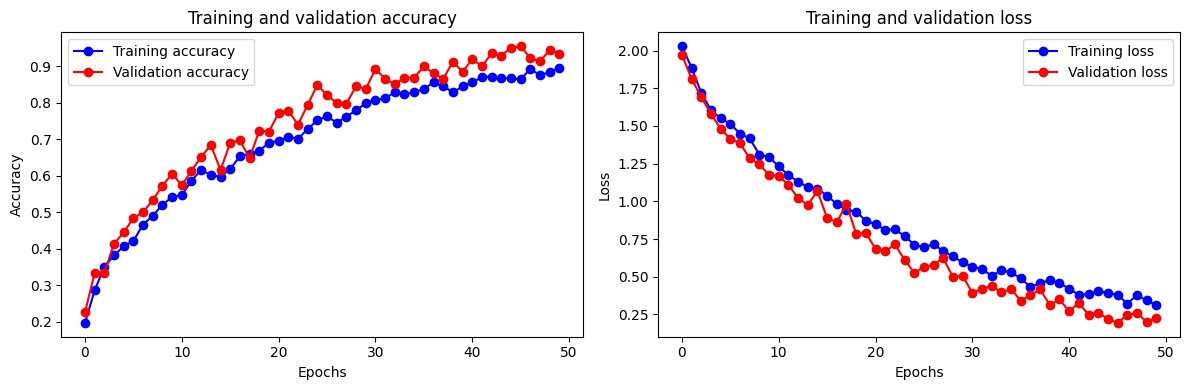

In [ ]:
import matplotlib.pyplot as plt

# Extract information from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Print history details
print("Epochs:", history.epoch)
print("Params:", history.params)
print("Keys in history.history:", history.history.keys())

# Plot training vs. validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training vs. validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelBinarizer

# Make predictions
y_pred_prob = model.predict(X)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

# Display the metrics
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Detailed classification report
print("\nClassification Report:\n", classification_report(y, y_pred))

48/48 [==============================] - 15s 299ms/step
Precision: 65.52%
Recall: 52.47%
F1 Score: 52.94%

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78       192
           1       0.33      0.83      0.48       187
           2       0.83      0.30      0.45       181
           3       0.86      0.35      0.50       179
           4       0.55      0.53      0.54       198
           5       0.99      0.39      0.56       194
           6       0.40      0.58      0.48       200
           7       0.48      0.44      0.46       182

    accuracy                           0.53      1513
   macro avg       0.66      0.52      0.53      1513
weighted avg       0.65      0.53      0.53      1513



In [ ]:
model.save('/content/drive/My Drive/NewCroppedShot/lrcn-new-data-tuned-model-8label-max.keras')

In [ ]:
# from google.colab import files

# uploaded = files.upload()

# # Move the uploaded video to a specific directory
# os.makedirs('videos', exist_ok=True)
# for file_name in uploaded.keys():
#     os.rename(file_name, os.path.join('videos', file_name))



Saving 3.mp4 to 3.mp4


In [ ]:
# video_path = 'videos/3.mp4'
# new_frames = extract_frames(video_path)
# new_frames = np.expand_dims(new_frames, axis=0)
# new_frames = np.expand_dims(new_frames, axis=-1)

# prediction = model.predict(new_frames)
# predicted_class = np.argmax(prediction, axis=1)
# print(prediction)
# shot = {0: 'Defensive Shot', 1: 'Pull Shot', 2: 'Drive Shot', 3: 'Flick Shot'}
# print(shot[predicted_class[0]])
# # labels = {'Defensive Shot': 0,  'Pull Shot': 1, 'Drive Shot':2, 'Flick Shot':3}
# #print('Predicted class:', 'Defensive shot' if predicted_class[0] == 0 else 'Drive Shot')

1/1 [==============================] - 0s 48ms/step
[[2.8614295e-03 2.1590880e-04 9.9665856e-01 2.6406694e-04]]
Drive Shot
